# EDA

**In this notebook, we will introduce and then explore the data by creating different sorts of visualizations of the play by play data. The goal is to find variables which would be interesting for our win probability model.**

# Introduction

Building Win Probability Models is an interesting task given the potential applications of such models in the massive fields of sports analysis and betting. It is a growing practice in recent years for sites to publish their own win probability graphics, but the statistics behind most of these models are not publically available. Therefore, we were excited to develop our own such model.

The major challenges of this project were scraping the play-by-play data from Basketball Reference, engineering variables from scraped text, and finding a balance between overfitting and underfitting during model development.

# Scraping Success & Challenges

With data collection being one of the bigger challenges in the sports project, we decided to begin with the starter code to scrape from Basketball Reference. This provided us with a solid starting point to continue adding and engineering features for our win probability model. 

We wanted to end up with many more columns which extract information from the play-by-play event text, so we scraped more data from Basketball Refernce (scraping code in separate jupyter notebook).

The starter code provided us with a final table which included: time left in the quarter, away team event description, away team points, score (as text), home team points, home team events, away team name, home team name, event description, and a Boolean variable isAwayEvent. We had a few observations:

Our first observation was that time left in the quarter may not be as representative of win probability as total time remaining. This led to us engineering a continuous quantitative variable ‘timeRemaining’ which ranges from 48 to 0 in float form. This variable also resets at the start of each overtime to 5 minutes remaining.

After this, we moved on to the crucial task of extracting information from the event. We noticed that there are several event types: Assist, Offensive Rebound, Defensive Rebound, 3pt Shot, 2pt Shot, Free Throw, and Turnover. Therefore we created Boolean variables for each of these variables, i.e. is this event a 3pt shot, if so then “1” else “0”. In addition to these variables, we also added ‘isMade’ for a made shot, ‘isMissed’ for a missed shot, ‘shotDistance’ to capture the distance of the shot, ‘awayRun’ to capture consecutive points scored (positive if the away team continues to score, negative if the home team continues to score).

Lastly, we added ‘points_on_play’ and 'primary_player' involved in each play for EDA purposes. This allowed us to compare the efficiency of teams when they are home and away.

Some of the biggest challenges of the scraping process were as follows:

1. Figuring out how to scrape games in November only up until 11/26, as instructed

2. Extracting primary player from event strings

3. Creating "isFoul" boolean, which we eventually decided to delete because Basketball Reference did not always list fouls on the away team in the away column, or vice versa for the home team, and because "isFoul" would most likely be accounted for in "isFT" (defensive foul) or "isTurnover" (offensive foul)

4. Extracting and calculating 'awayRun' and 'minutesRemaining' 

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
import seaborn.apionly as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from matplotlib  import cm
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import warnings
warnings.filterwarnings(action='once')

In [21]:
# import scraped data
pbp = pd.read_csv("pbp2.csv")
pbp = pbp.iloc[:,1:]

In [22]:
pbp.describe()

,isawayevent,awayscore,homescore,quarter,gameID,isAssist,isOffRebound,isDefRebound,is3ptShot,is2ptShot,isFT,isMade,isMissed,isTurnover,shotDistance,awayRun,awayLead,minutesRemaining,points_on_play,AWAY_WIN
count,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000,132330.000000
mean,0.508297,53.179869,54.482695,2.521930,142.814555,0.097695,0.068118,0.157666,0.126185,0.246921,0.096599,0.243890,0.225814,0.003212,4.945175,-0.112454,-1.302826,23.349436,0.459284,0.424998
std,0.499933,31.388282,32.029916,1.118093,83.357931,0.296903,0.251949,0.364429,0.332058,0.431222,0.295413,0.429429,0.418119,0.056581,9.027741,3.971640,11.214979,13.877395,0.877616,0.494345
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-28.000000,-49.000000,0.000000,0.000000,0.000000
25%,0.000000,26.000000,27.000000,2.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,-8.000000,11.433333,0.000000,0.000000
50%,1.000000,52.000000,54.000000,3.000000,143.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,23.733333,0.000000,0.000000
75%,1.000000,79.000000,81.000000,4.000000,215.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,5.000000,35.466667,0.000000,1.000000
max,1.000000,142.000000,146.000000,4.000000,288.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,86.000000,19.000000,58.000000,48.000000,3.000000,1.000000


## EDA Plots & Findings
- The mean value for Offensive Rebounds compared to Defensive Rebounds is 0.0681 and 0.1576 respectively. This tells us that Offensive Rebounds are much less common than Defensive Rebounds. Perhaps this will be an important factor in the model given that offensive rebounds lead to more scoring opportunities.
- We can see that the mean value for 3pt and 2pt shots respectively are 0.1262 and 0.2469 showing that 3pt attempts are half as likely as 2pt shots, i.e. one third of shot attempts are 3pt shots.
- Another interesting find is that the average shot distance is 14.5 ft with a standard deviation of 10 ft. 
- Additionally, we can see that 40% of shots made were assisted. When looking at made shots exclusively, we see that 51% are 2pt shots, 18.6% are 3pt shots, and 30.4% are free throws. On the other hand, looking at misses exclusively, we see that 54.3% of missed shots are 2pt, 35.7% are 3pt, and 10% are free throws
- We also noted that the average away lead is -1.3 suggesting that the home team leads on average during the play by play calls. This works with away win percentage, 42.76%, suggesting that the away not only trails the home team on average but they also win less than 50% of the team.
- On average, the points per shot is 1 as expected. This suggests that teams are hitting 2pt shots with 50% accuracy typically and 3pt shots with 33% accuracy. See below for a comparison per team.


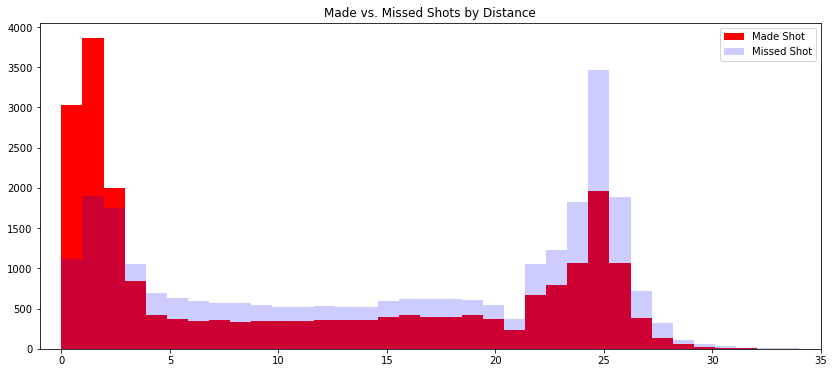

In [11]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
made = pbp[(pbp['isMade'] == 1) & (pbp['isFT'] == 0) & (pbp['shotDistance'] < 35)]
missed = pbp[(pbp['isMissed'] == 1) & (pbp['isFT'] == 0) & (pbp['shotDistance'] < 35)]
made['shotDistance'].hist(bins=35, figsize=[14,6], color='red', label='Made Shot')
missed['shotDistance'].hist(bins=35, figsize=[14,6], alpha=0.2, color='blue', label="Missed Shot")
ax.legend(loc='best')
ax.grid(False)
ax.set_xlim(-1,35)
plt.title("Made vs. Missed Shots by Distance")

**This plot shows us that shots around the rim are higher in conversion rate than distant shots, however they are attempted with similar rates.**

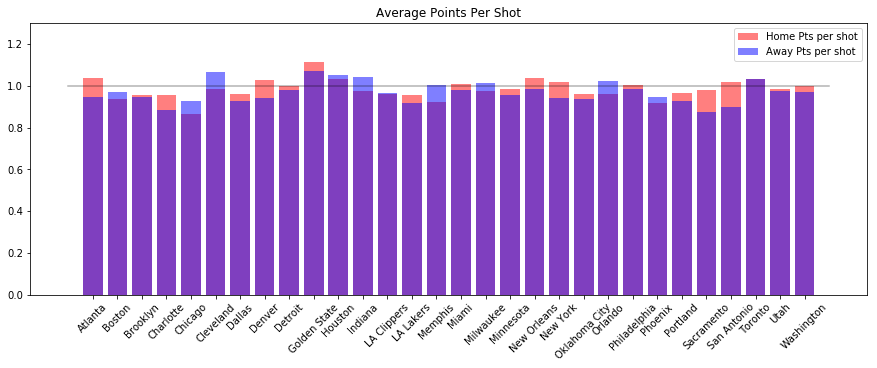

In [48]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
teams = pbp.awayteam.unique()
teams.sort()
y_pos = np.arange(len(teams))
avg_home = pbp[(pbp.isawayevent == 0) & ((pbp.isMade == 1) | (pbp.isMissed == 1))].groupby(['hometeam'])['points_on_play'].mean()
avg_away = pbp[(pbp.isawayevent == 1) & ((pbp.isMade == 1) | (pbp.isMissed == 1))].groupby(['awayteam'])['points_on_play'].mean()

plt.bar(y_pos, avg_home, align='center', alpha=0.5, color='red', label='Home Pts per shot')
plt.bar(y_pos, avg_away, align='center', alpha=0.5, color='blue', label='Away Pts per shot')
plt.xticks(y_pos, teams)
plt.plot((-1, 30), (1, 1), 'black', alpha=0.3)
ax.legend(loc='best')
ax.set_ylim(0,1.3)
plt.title('Average Points Per Shot')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

**This plot shows which teams out perform the 1pt per shot expected average and shows which teams shoot better home vs away**

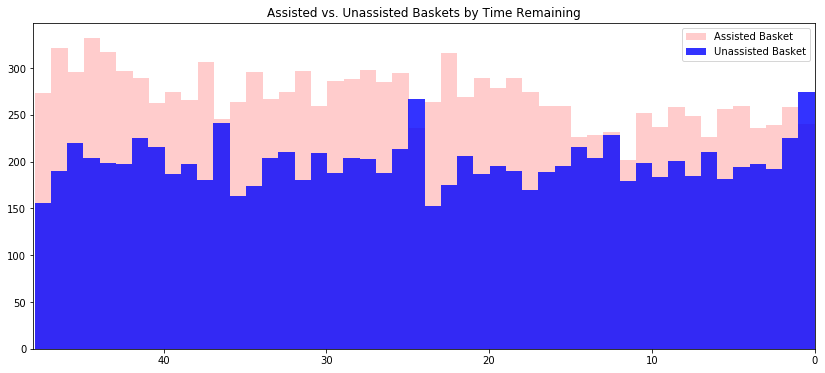

In [7]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
assisted = pbp[(pbp['isMade'] == 1) & (pbp['isAssist'] == 1) & (pbp['isFT'] == 0)]
unassisted = pbp[(pbp['isMade'] == 1) & (pbp['isAssist'] == 0) & (pbp['isFT'] == 0)]
assisted['minutesRemaining'].hist(bins=48, figsize=[14,6], alpha=0.2, color='red', label='Assisted Basket')
unassisted['minutesRemaining'].hist(bins=48, figsize=[14,6], alpha=0.8, color='blue', label="Unassisted Basket")
ax.legend(loc='best')
ax.grid(False)
ax.set_xlim(48,0)
plt.title("Assisted vs. Unassisted Baskets by Time Remaining")

**This plot gives us a sense of how teams are passing the ball depending on the amount of time left. It appears that players get slightly more selfish near the end of quarters.**

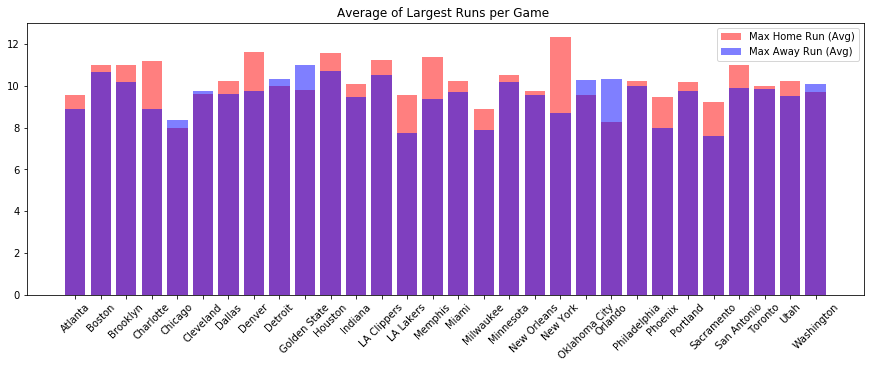

In [10]:
homeMaxs = pbp.groupby(['gameID'])['awayRun'].min()
homeTeams = []
j = []
for i in pbp.hometeam:
    if (i != j):
        homeTeams.append(i)
    j = i
awayMaxs = pbp.groupby(['gameID'])['awayRun'].max()
awayTeams = []
for i in pbp.awayteam:
    if (i != j):
        awayTeams.append(i)
    j = i

MaxRuns = pd.DataFrame({'homeTeam':homeTeams, 'MaxHomeRun':homeMaxs, 'awayTeam':awayTeams, 'MaxAwayRun':awayMaxs})
fig, ax = plt.subplots(1,1,figsize=(15,5))
teams = pbp.awayteam.unique()
teams.sort()
y_pos = np.arange(len(teams))
avg_home_run = MaxRuns.groupby(['homeTeam'])['MaxHomeRun'].mean()
avg_away_run = MaxRuns.groupby(['awayTeam'])['MaxAwayRun'].mean()

plt.bar(y_pos, -avg_home_run, align='center', alpha=0.5, color='red', label='Max Home Run (Avg)')
plt.bar(y_pos, avg_away_run, align='center', alpha=0.5, color='blue', label='Max Away Run (Avg)')
plt.xticks(y_pos, teams)
ax.legend(loc='best')
ax.set_ylim(0,13)
plt.title('Average of Largest Runs per Game ')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

**This plot shows that a team's longest run within a game is typically higher during home games than away games. One possible explanation for this would be that home crowds motivate teams that are doing well to continue doing well.**

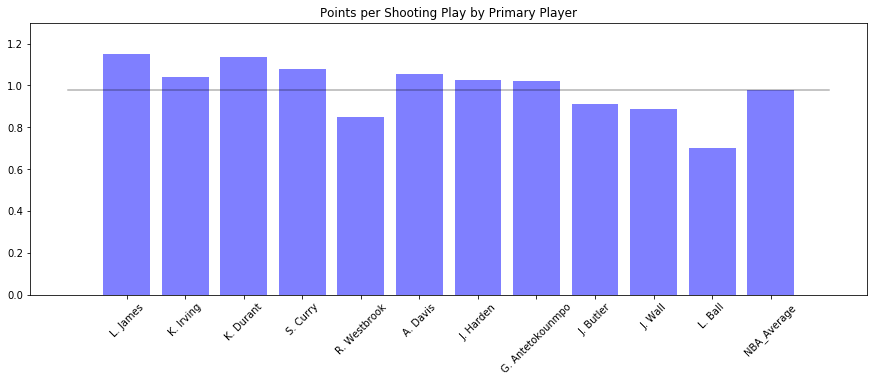

In [40]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
players = ['L. James', 'K. Irving', 'K. Durant', 'S. Curry', 'R. Westbrook', 'A. Davis', 
           'J. Harden', 'G. Antetokounmpo', 'J. Butler', 'J. Wall', 'L. Ball', 'NBA_Average']
y_pos = np.arange(len(players))
ppp = []
for i in players:
    if (i != 'NBA_Average'):
        plays = pbp[(pbp.primary_player == i) & ((pbp.isMade == 1) | (pbp.isMissed == 1))]
        ppp.append(plays["points_on_play"].mean())
    else:
        plays = pbp[(pbp.primary_player != "N/A") & ((pbp.isMade == 1) | (pbp.isMissed == 1))]
        ppp.append(plays["points_on_play"].mean())

plt.bar(y_pos, ppp, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, players)
plt.plot((-1, len(ppp)), (ppp[-1],ppp[-1]), 'black', alpha=0.3)
plt.title('Points per Shooting Play by Primary Player')
plt.ylim([0, 1.3])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

**This plot gives us a sense of how the top players in the NBA compare to the NBA average for points per shot attempt. As we can see here, the top players, such as James, Irving, Curry, and Durant are slightly above the NBA Average.**

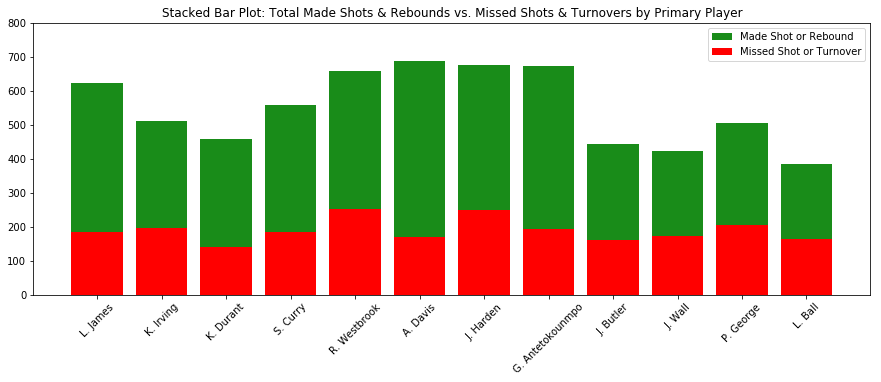

In [52]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
players = ['L. James', 'K. Irving', 'K. Durant', 'S. Curry', 'R. Westbrook', 'A. Davis', 
           'J. Harden', 'G. Antetokounmpo', 'J. Butler', 'J. Wall', 'P. George', 'L. Ball']
y_pos = np.arange(len(players))
total_pp = []
bp_pp = []
for i in players:
    good_plays = pbp[(pbp.primary_player == i) & ((pbp.isMade == 1) | (pbp.isOffRebound == 1) | (pbp.isDefRebound == 1))]
    bad_plays = pbp[(pbp.primary_player == i) & ((pbp.isMissed == 1) | (pbp.isTurnover == 1))]
    total_pp.append(int(len(good_plays)) + int(len(bad_plays)))
    bp_pp.append(int(len(bad_plays)))

plt.bar(y_pos, total_pp, align='center', alpha=0.9, color='green', label='Made Shot or Rebound')
plt.bar(y_pos, bp_pp, align='center', alpha=1, color='red', label='Missed Shot or Turnover')
plt.xticks(y_pos, players)
plt.title('Stacked Bar Plot: Total Made Shots & Rebounds vs. Missed Shots & Turnovers by Primary Player')
plt.ylim([0, 800])
ax.legend(loc='best')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

**This plot shows how many plays each top players in the NBA are primarily involved in, as well as the portion of those plays that are "good" or "bad."**